# Chapter 4: Geocentric Models - Samples

In [1]:
from scipy import stats
from matplotlib import pyplot as plt
import pathlib
import pandas as pd
import numpy as np
import arviz as az
from scipy.interpolate import griddata
import pymc as pm
from patsy import dmatrix

**4E1** In the model definition below, which line is the likelihood?

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(0, 10)$$
$$\sigma \sim \text{Exponential}(1)$$

Answer:

The line is $y_i \sim \text{Normal}(\mu, \sigma)$

**4E2** In the model definition just above, how many parameters are in the posterior distribution?

Answer:

2

**4E3** Using the model definition above, write down the appropriate form of Bayes' theorem that includes the proper likelihood and priors.

Answer:

$$\text{Pr}(\mu, \sigma|D) = \frac{\prod_i \text{Normal} (D|\mu, \sigma) \text{Normal} (\mu|0, 10) \text{Exponential} (\sigma|1) }{\int \int \prod_i \text{Normal} (D|\mu, \sigma) \text{Normal} (\mu|0, 10) \text{Exponential} (\sigma|1) d\mu d\sigma}$$

**4E4** In the model definition below, which line is the linear model?

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta x_i$$
$$\alpha \sim \text{Normal}(0, 10)$$
$$\beta \sim \text{Normal}(0, 1)$$
$$\sigma \sim \text{Exponential}(2)$$

Answer:

The line is $\mu_i = \alpha + \beta x_i$

**4E5** In the model definition just above, how many parameters are in the posterior distribution?

Answer:

3

**4M1** For the model definition below, simulate observed $y$ values from the prior (not the posterior).

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(0, 10)$$
$$\sigma \sim \text{Exponential}(1)$$

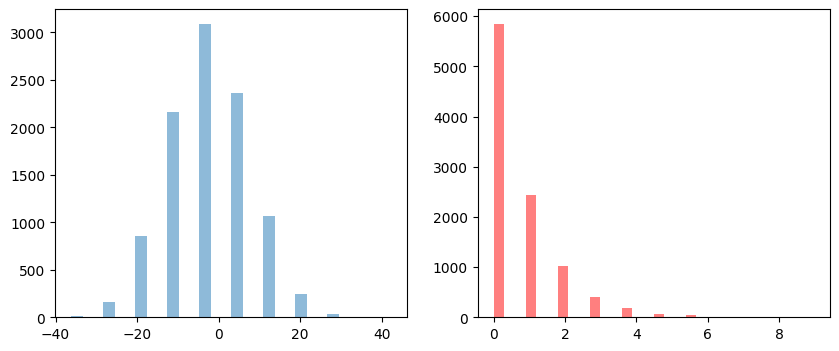

In [23]:
mu = np.random.normal(loc=0, scale=10, size=10_000)
sigma = np.random.exponential(scale=1, size=10_000)
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(mu, width=3, alpha=0.5)
plt.subplot(1, 2, 2)
plt.hist(sigma, width=0.3, color='r', alpha=0.5);

**4M2** Translate the model just above into a `quap` formula.

In [21]:
with pm.Model() as m42:
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)
    height = pm.Normal('height', mu=mu, sigma=sigma)

**4M3** Translate the `quap` model formula below into a mathematical model definition.

```R
y ~ dnorm(mu, sigma),
mu <- a + b*x,
a ~ dnorm( 0, 10 ),
b ~ dunif( 0, 1 ),
sigma ~ dexp( 1 )
```

Answer:

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta x_i$$
$$\alpha \sim \text{Normal}(0, 10)$$
$$\beta \sim \text{Uniform}(0, 1)$$
$$\sigma \sim \text{Exponential}(1)$$

**4M4** A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

Answer:

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta(\text{year}_i - \bar{\text{year}})$$
$$\alpha \sim \text{Normal}(160, 20)$$
$$\beta \sim \text{Log-Normal}(0, 1)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

**4M5** Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

Answer:

No, it doesn't. The Log-Normal already assumes a positive growth.

**4M6** Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

Answer:

$$\sigma \sim \text{Uniform}(0, 64)$$

**4M7** Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the new model's posterior to that of the original model. In particular, look at the variance among the parameters. What is different? Then compare the posterior predictions of both models.

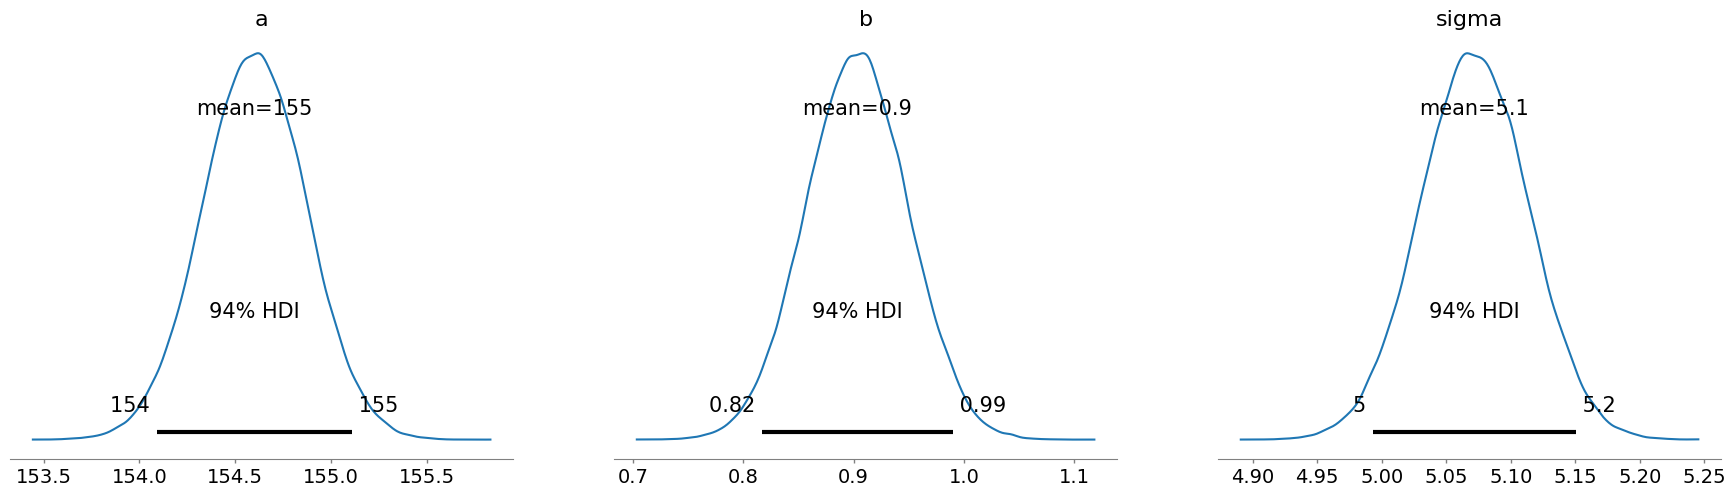

In [28]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# define the average weight, x-bar
xbar = d2['weight'].mean()

# fit model
with pm.Model() as m4_3:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*(d2['weight'] - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3)
H = pm.find_hessian(mean_q, model=m4_3)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3 = stats.multivariate_normal(mean=mean, cov=cov)

samples = {}

samples_out = posterior4_3.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

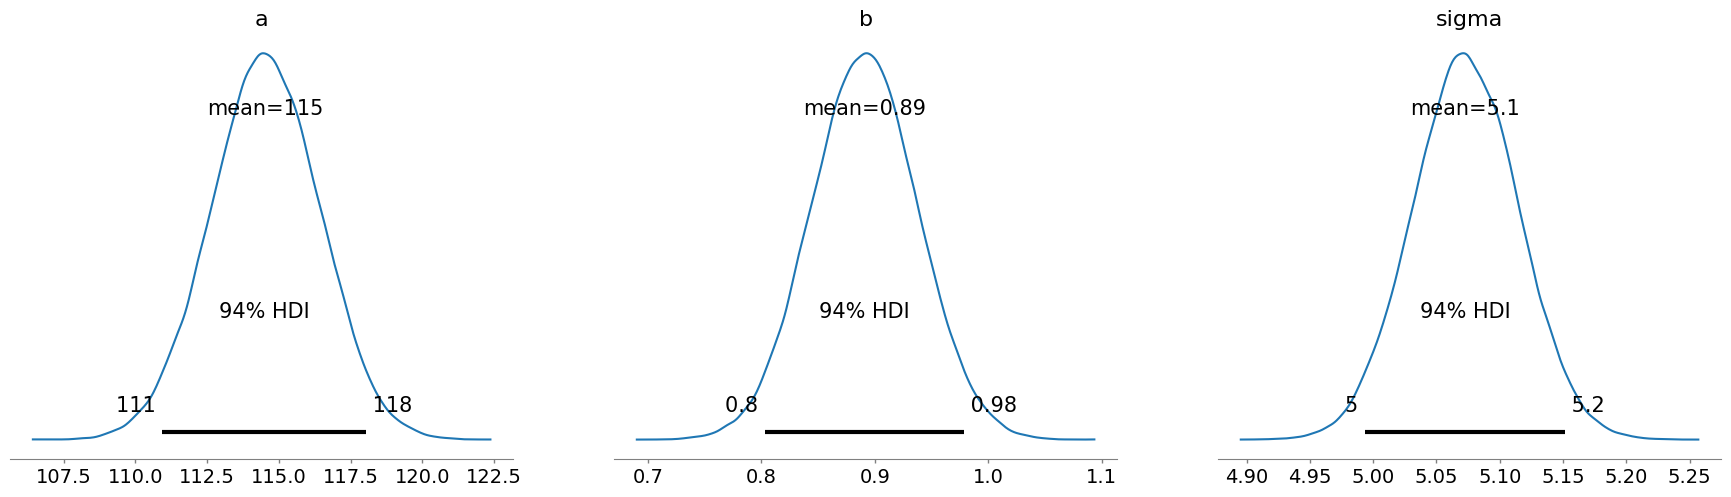

In [29]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# fit model
with pm.Model() as m4_3c:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*d2['weight']
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3c)
H = pm.find_hessian(mean_q, model=m4_3c)
cov2 = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3c = stats.multivariate_normal(mean=mean, cov=cov2)

samples = {}

samples_out = posterior4_3c.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

In [47]:
with np.printoptions(precision=3, suppress=True):
    print('With xbar:\n {}'.format(cov.round(3)))
    print('Without xbar:\n {}'.format(cov2.round(3)))

With xbar:
 [[ 0.073 -0.     0.   ]
 [-0.     0.002 -0.   ]
 [ 0.    -0.     0.002]]
Without xbar:
 [[ 3.601 -0.088  0.002]
 [-0.088  0.002 -0.   ]
 [ 0.002 -0.     0.002]]


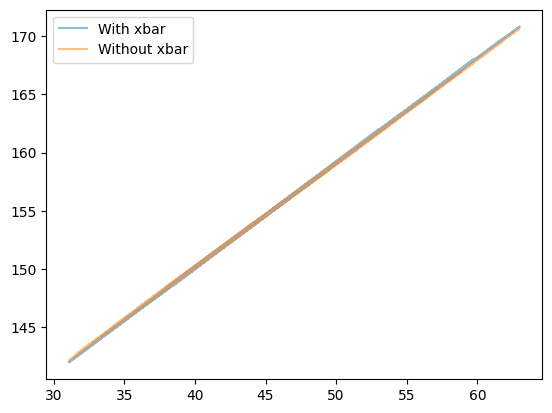

In [57]:
def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (seq - seq.mean())
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

height_v1_mean = sim(posterior4_3, d2['weight'].values).mean(axis=0)

def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * seq
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

height_v2_mean = sim(posterior4_3c, d2['weight'].values).mean(axis=0)

plt.plot(d2['weight'], height_v1_mean, label='With xbar', alpha=0.5)
plt.plot(d2['weight'], height_v2_mean, label='Without xbar', alpha=0.5);
plt.legend();

**4M8** In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights—change the standard deviation of the prior and watch what happens. What do you think the combination of knot number and the prior on the weights controls?

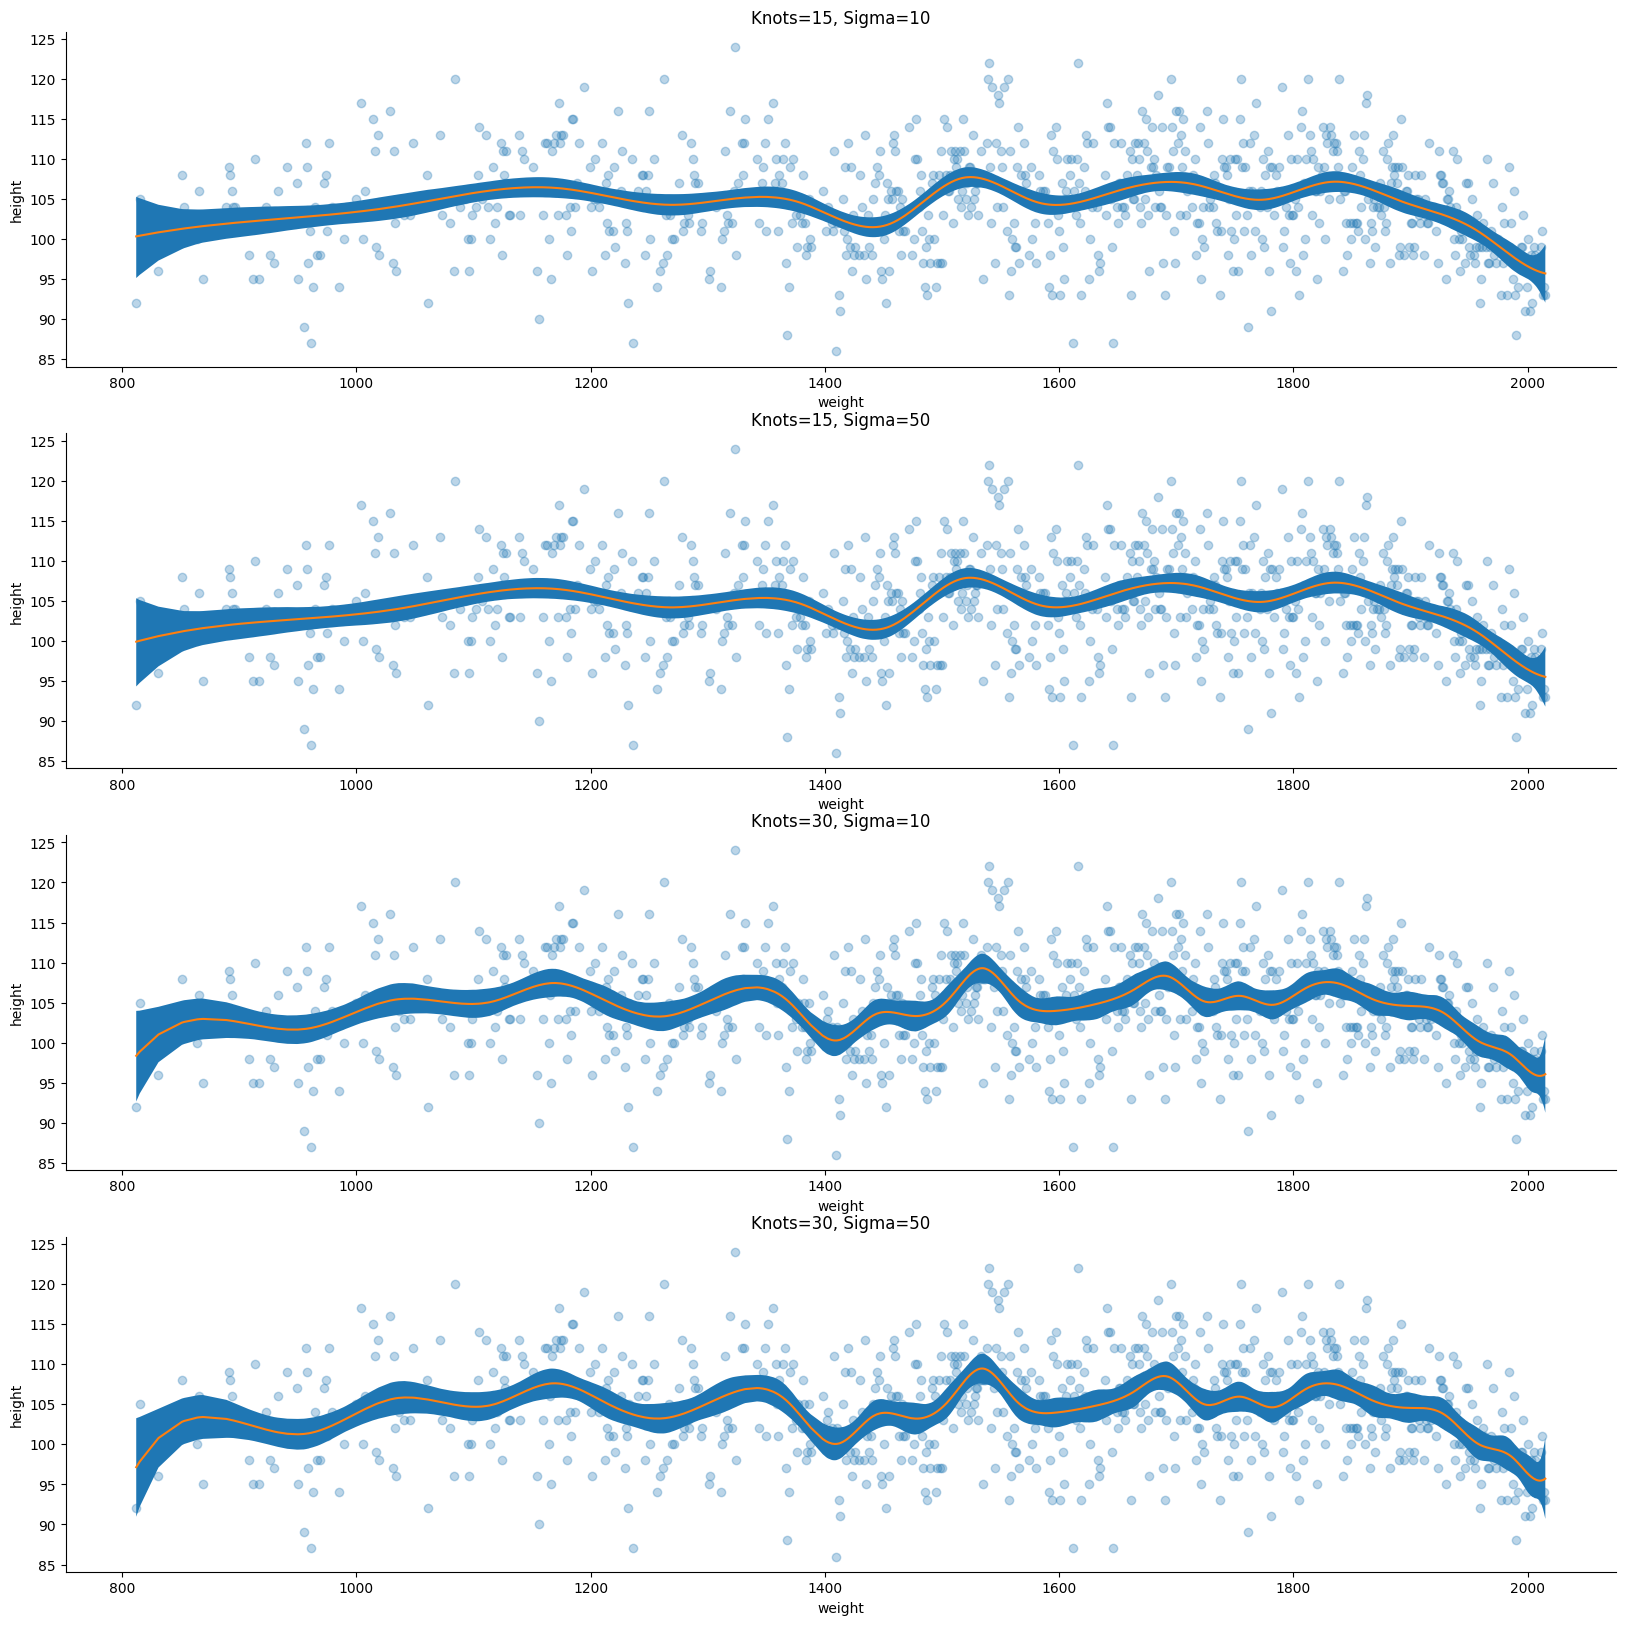

In [80]:
import itertools

d = pd.read_csv(DATA_PATH.joinpath('cherry_blossoms.csv'))
d2 = d.dropna(subset=['doy'])
_, axs = plt.subplots(4, 1, figsize=(20, 20))
axs = axs.flatten()

num_knots = [15, 30]
prior_sigma = [10, 50]

combinations = itertools.product(num_knots, prior_sigma)

for i, (num_knot, w_sigma) in enumerate(combinations):
    knot_list = np.quantile(d2['year'], np.linspace(0, 1, num_knot))

    # Generate B-Splines
    B = dmatrix(
        "bs(year, knots=knots, degree=3, include_intercept=True)-1",
        {"year": d2['year'].values, "knots": knot_list[1:-1]},
    )

    with pm.Model() as cherry_model:
        a = pm.Normal('a', 100, 10)
        w = pm.Normal('w', mu=0, sigma=w_sigma, shape=B.shape[1])
        mu = pm.Deterministic('mu', a + pm.math.dot(B.base, w.T))
        sigma = pm.Exponential('sigma', 1)
        D = pm.Normal('D', mu, sigma, observed=d2['doy'].values)

    mean_q = pm.find_MAP(model=cherry_model)
    H = pm.find_hessian(mean_q, model=cherry_model)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, w, sigma]])
    posterior = stats.multivariate_normal(mean=mean, cov=cov)

    def link(posterior, seq):
        post = posterior.rvs(size=10_000)
        weights_seq = np.tile(seq, (10_000, 1))
        mu = post[:, 0:1] + np.dot(post[:, 1:-1], seq[:, :].T)
        return mu

    mu = link(posterior, B);
    mu_mean = mu.mean(axis=0)
    mu_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

    axs[i].plot(d2['year'], d2['doy'], 'o', alpha=0.3)
    axs[i].plot(d2['year'], mu_mean)
    axs[i].fill_between(d2['year'], mu_pi[:, 0], mu_pi[:, 1])

    axs[i].spines.right.set_visible(False)
    axs[i].spines.top.set_visible(False)
    axs[i].set_xlabel('weight')
    axs[i].set_ylabel('height')
    axs[i].set_title(f'Knots={num_knot}, Sigma={w_sigma}');

By increasing the number of knots, the model fits even more to the data. While increasing the variation of the $\sigma$ prior, makes no difference.